In [1]:
import os
import sys
HOME_DIR = '/Users/anhdang/Documents/Github/COS40007-Artificial-Intelligence-for-Engineering'
os.chdir(HOME_DIR)

DATASETS_DIR = f'{HOME_DIR}/datasets'
DATA_DIR = f'{DATASETS_DIR}/10/coroision_train'
NO_RUST_DATASET_FOLDER = f'{DATA_DIR}/no_rust'
RUST_DATASET_FOLDER = f'{DATA_DIR}/rust'
TEST_DIR = f'{DATASETS_DIR}/10/coroision_test'
LOG_LABEL_DATASET_FOLDER = f'{DATASETS_DIR}/10/log-labelled'
COCO_ANNOTATIONS_DIR = f'{DATASETS_DIR}/10/coco_annotations'

os.makedirs(TEST_DIR, exist_ok=True)
os.makedirs(f'{TEST_DIR}/no_rust', exist_ok=True)
os.makedirs(f'{TEST_DIR}/rust', exist_ok=True)
os.makedirs(COCO_ANNOTATIONS_DIR, exist_ok=True)

print(f'HOME_DIR: {HOME_DIR}')
print(f'DATASETS_DIR: {DATASETS_DIR}')
print(f'DATA_DIR: {DATA_DIR}')
print(f'RUST_DATASET_FOLDER: {RUST_DATASET_FOLDER}')
print(f'NO_RUST_DATASET_FOLDER: {NO_RUST_DATASET_FOLDER}')
print(f'COCO_ANNOTATIONS_DIR: {COCO_ANNOTATIONS_DIR}')

HOME_DIR: /Users/anhdang/Documents/Github/COS40007-Artificial-Intelligence-for-Engineering
DATASETS_DIR: /Users/anhdang/Documents/Github/COS40007-Artificial-Intelligence-for-Engineering/datasets
DATA_DIR: /Users/anhdang/Documents/Github/COS40007-Artificial-Intelligence-for-Engineering/datasets/10/coroision_train
RUST_DATASET_FOLDER: /Users/anhdang/Documents/Github/COS40007-Artificial-Intelligence-for-Engineering/datasets/10/coroision_train/rust
NO_RUST_DATASET_FOLDER: /Users/anhdang/Documents/Github/COS40007-Artificial-Intelligence-for-Engineering/datasets/10/coroision_train/no_rust
COCO_ANNOTATIONS_DIR: /Users/anhdang/Documents/Github/COS40007-Artificial-Intelligence-for-Engineering/datasets/10/coco_annotations


In [2]:
!pip install --upgrade pip --quiet
!pip install -r requirements.txt --quiet

In [2]:
import random
import shutil
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.optim as optim
from torchvision import models
from torchvision.datasets import ImageFolder


In [4]:
# device = torch.device("mps") if torch.backends.mps.is_available() else torch.device("cpu")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'Using device: {device}')

Using device: cpu


# Tasks 1

Preparing Dataset

In [35]:
# Function to randomly select images for the test set
def select_images(src_folder, dest_folder, num_images=10):
    images = os.listdir(src_folder)
    selected_images = random.sample(images, num_images)
    for image in selected_images:
        shutil.move(os.path.join(src_folder, image), os.path.join(dest_folder, image))

# Move 10 images from each category to the test set
select_images(NO_RUST_DATASET_FOLDER, f'{TEST_DIR}/no_rust', num_images=10)
select_images(RUST_DATASET_FOLDER, f'{TEST_DIR}/rust', num_images=10)

print("Test set created with 10 rust and 10 no_rust images.")

Test set created with 10 rust and 10 no_rust images.


In [36]:
# Load and check dataset labels
dataset = ImageFolder(DATA_DIR)
print("Classes:", dataset.classes)
print("Class to index mapping:", dataset.class_to_idx)

# Check if the labels are correct
labels = [label for _, label in dataset]
print("Unique labels in the dataset:", set(labels))


Classes: ['no_rust', 'rust']
Class to index mapping: {'no_rust': 0, 'rust': 1}
Unique labels in the dataset: {0, 1}


In [37]:
# Data transformation
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

# Load training dataset (only rust and no_rust)
train_dataset = datasets.ImageFolder(DATA_DIR, transform=transform)

# Load test dataset from the separate test directory
test_dataset = datasets.ImageFolder(TEST_DIR, transform=transform)

# Data loaders
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=4, shuffle=False)

# Verify the classes and label indices
print(f"Training set size: {len(train_loader.dataset)}")
print(f"Test set size: {len(test_loader.dataset)}")
print(f"Classes in training set: {train_dataset.classes}")
print(f"Classes in test set: {test_dataset.classes}")


Training set size: 630
Test set size: 40
Classes in training set: ['no_rust', 'rust']
Classes in test set: ['no_rust', 'rust']


SimpleCNN

In [39]:
# Simple CNN model
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        self.fc1 = nn.Linear(32 * 56 * 56, 128)
        self.fc2 = nn.Linear(128, 2)  # Output layer for 2 classes: rust and no_rust

    def forward(self, x):
        x = torch.relu(self.conv1(x))
        x = torch.max_pool2d(x, 2)
        x = torch.relu(self.conv2(x))
        x = torch.max_pool2d(x, 2)
        x = x.view(-1, 32 * 56 * 56)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Initialize the model, loss function, and optimizer
simplecnn = SimpleCNN()
simplecnn.to(device)
criterion = nn.CrossEntropyLoss()  # Use CrossEntropyLoss for multi-class classification
optimizer = optim.Adam(simplecnn.parameters(), lr=0.001)

print("SimpleCNN model initialized.")

SimpleCNN model initialized.


In [40]:
# Training loop
num_epochs = 10
for epoch in range(num_epochs):
    simplecnn.train()
    running_loss = 0.0
    for images, labels in train_loader:
        optimizer.zero_grad()
        outputs = simplecnn(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {running_loss/len(train_loader):.4f}')

# Save the trained model
torch.save(simplecnn.state_dict(), 'simple_cnn.pth')

print("Training complete. Model saved as 'simple_cnn.pth'.")

Epoch 1/10, Loss: 0.8018
Epoch 2/10, Loss: 0.5340
Epoch 3/10, Loss: 0.4194
Epoch 4/10, Loss: 0.4264
Epoch 5/10, Loss: 0.3648
Epoch 6/10, Loss: 0.3227
Epoch 7/10, Loss: 0.3122
Epoch 8/10, Loss: 0.2698
Epoch 9/10, Loss: 0.2298
Epoch 10/10, Loss: 0.1890
Training complete. Model saved as 'simple_cnn.pth'.


In [41]:
# Evaluation
simplecnn.eval()
correct = 0
total = 0
with torch.no_grad():
    for images, labels in test_loader:
        outputs = simplecnn(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = 100 * correct / total
print(f'Accuracy of the Simple CNN model on the test set: {accuracy:.2f}%')

# Save test results
test_results = []
for i, (images, labels) in enumerate(test_loader):
    outputs = simplecnn(images)
    _, predicted = torch.max(outputs.data, 1)
    for j in range(images.size(0)):
        test_results.append((labels[j].item(), predicted[j].item()))

# Write results to a file
with open('cnn_test_results.txt', 'w') as f:
    for true, pred in test_results:
        f.write(f"True: {true}, Predicted: {pred}\n")

print("Test results saved to 'cnn_test_results.txt'.")


Accuracy of the Simple CNN model on the test set: 87.50%
Test results saved to 'cnn_test_results.txt'.


Resnet50

In [42]:
# Load the pre-trained ResNet50 model
resnet50 = models.resnet50(pretrained=True)
num_ftrs = resnet50.fc.in_features
resnet50.fc = nn.Linear(num_ftrs, 2)  # Adjust the final layer for 2 classes: rust and no_rust

# Use the same loss function and optimizer
optimizer = optim.Adam(resnet50.parameters(), lr=0.001)

resnet50.to(device)
# Training the ResNet50 model
for epoch in range(num_epochs):
    resnet50.train()
    running_loss = 0.0
    for images, labels in train_loader:
        optimizer.zero_grad()
        outputs = resnet50(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {running_loss/len(train_loader):.4f}')

# Save the ResNet50 model
torch.save(resnet50.state_dict(), 'resnet50.pth')

print("ResNet50 model training complete. Model saved as 'resnet50.pth'.")

Epoch 1/10, Loss: 0.6413
Epoch 2/10, Loss: 0.4348
Epoch 3/10, Loss: 0.3388
Epoch 4/10, Loss: 0.3723
Epoch 5/10, Loss: 0.3126
Epoch 6/10, Loss: 0.3812
Epoch 7/10, Loss: 0.3050
Epoch 8/10, Loss: 0.2634
Epoch 9/10, Loss: 0.1976
Epoch 10/10, Loss: 0.2493
ResNet50 model training complete. Model saved as 'resnet50.pth'.


In [43]:
# Evaluation
resnet50.eval()
correct = 0
total = 0
with torch.no_grad():
    for images, labels in test_loader:
        outputs = resnet50(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = 100 * correct / total
print(f'Accuracy of the ResNet50 model on the test set: {accuracy:.2f}%')

# Save ResNet50 test results
test_results_resnet = []
for i, (images, labels) in enumerate(test_loader):
    outputs = resnet50(images)
    _, predicted = torch.max(outputs.data, 1)
    for j in range(images.size(0)):
        test_results_resnet.append((labels[j].item(), predicted[j].item()))

# Write results to a file
with open('resnet50_test_results.txt', 'w') as f:
    for true, pred in test_results_resnet:
        f.write(f"True: {true}, Predicted: {pred}\n")

print("ResNet50 test results saved to 'resnet50_test_results.txt'.")


Accuracy of the ResNet50 model on the test set: 92.50%
ResNet50 test results saved to 'resnet50_test_results.txt'.


# Task 2

In [5]:
import labelme2coco

# Set the folder for LabelMe annotations and images
labelme_folder = LOG_LABEL_DATASET_FOLDER

# Export directory for COCO annotations
export_dir = COCO_ANNOTATIONS_DIR

# Convert LabelMe annotations to COCO format
train_split_rate = 0.2  # 85% for training
category_id_start = 1  # Start category IDs from 1
labelme2coco.convert(labelme_folder, export_dir, train_split_rate, category_id_start=category_id_start)

print("LabelMe annotations converted to COCO format for log detection.")

There are 600 listed files in folder log-labelled.


Converting labelme annotations to COCO format: 100%|██████████| 600/600 [00:01<00:00, 325.31it/s]
09/05/2024 14:27:16 - INFO - labelme2coco -   Training split in COCO format is exported to /Users/anhdang/Documents/Github/COS40007-Artificial-Intelligence-for-Engineering/datasets/10/coco_annotations/train.json
09/05/2024 14:27:16 - INFO - labelme2coco -   Validation split in COCO format is exported to /Users/anhdang/Documents/Github/COS40007-Artificial-Intelligence-for-Engineering/datasets/10/coco_annotations/val.json


LabelMe annotations converted to COCO format for log detection.


In [6]:
from labelme2coco import get_coco_from_labelme_folder, save_json

# Set paths for train and validation directories
labelme_train_folder = LOG_LABEL_DATASET_FOLDER
labelme_val_folder = LOG_LABEL_DATASET_FOLDER

# Create the train COCO object
train_coco = get_coco_from_labelme_folder(labelme_train_folder, category_id_start=category_id_start)

# Export train COCO JSON
save_json(train_coco.json, os.path.join(export_dir, 'train_log.json'))

# Create validation COCO object using same categories as training
val_coco = get_coco_from_labelme_folder(labelme_val_folder, coco_category_list=train_coco.json_categories, category_id_start=category_id_start)

# Export validation COCO JSON
save_json(val_coco.json, os.path.join(export_dir, 'val_log.json'))

print("Train and validation JSON files for log detection saved in COCO format.")


There are 600 listed files in folder log-labelled.


Converting labelme annotations to COCO format: 100%|██████████| 600/600 [00:01<00:00, 466.71it/s]


There are 600 listed files in folder log-labelled.


Converting labelme annotations to COCO format: 100%|██████████| 600/600 [00:01<00:00, 414.21it/s]


Train and validation JSON files for log detection saved in COCO format.


In [7]:
import torch
from torch.utils.data import Dataset
from pycocotools.coco import COCO
import numpy as np
from PIL import Image
import os

class COCODataset(Dataset):
    def __init__(self, root, annotation, transforms=None):
        self.root = root
        self.coco = COCO(annotation)
        self.ids = list(sorted(self.coco.imgs.keys()))
        self.transforms = transforms

    def __getitem__(self, index):
        coco = self.coco
        img_id = self.ids[index]
        ann_ids = coco.getAnnIds(imgIds=img_id)
        anns = coco.loadAnns(ann_ids)
        img_info = coco.loadImgs(img_id)[0]
        path = img_info['file_name']

        # Load image
        img_path = os.path.join(self.root, path)
        img = Image.open(img_path).convert('RGB')

        # Load annotations
        num_objs = len(anns)
        boxes = []
        labels = []
        masks = []

        for ann in anns:
            xmin = ann['bbox'][0]
            ymin = ann['bbox'][1]
            width = ann['bbox'][2]
            height = ann['bbox'][3]
            xmax = xmin + width
            ymax = ymin + height
            boxes.append([xmin, ymin, xmax, ymax])
            labels.append(ann['category_id'])
            masks.append(coco.annToMask(ann))

        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        labels = torch.as_tensor(labels, dtype=torch.int64)
        masks = torch.as_tensor(np.stack(masks, axis=0), dtype=torch.uint8)

        image_id = torch.tensor([img_id])
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        iscrowd = torch.zeros((num_objs,), dtype=torch.int64)

        target = {}
        target['boxes'] = boxes
        target['labels'] = labels
        target['masks'] = masks
        target['image_id'] = image_id
        target['area'] = area
        target['iscrowd'] = iscrowd

        if self.transforms:
            img = self.transforms(img)

        return img, target

    def __len__(self):
        return len(self.ids)


In [8]:
# Define transformations
transform = transforms.Compose([
    transforms.ToTensor()
])

# Paths to images and COCO annotations
images_dir = LOG_LABEL_DATASET_FOLDER
train_json = os.path.join(COCO_ANNOTATIONS_DIR, 'train.json')
val_json = os.path.join(COCO_ANNOTATIONS_DIR, 'val.json')

# Create dataset instances
train_dataset = COCODataset(root=images_dir, annotation=train_json, transforms=transform)
val_dataset = COCODataset(root=images_dir, annotation=val_json, transforms=transform)

# Define a custom collate function to handle batches
def collate_fn(batch):
    return tuple(zip(*batch))

# Create DataLoader instances
train_loader = DataLoader(
    train_dataset,
    batch_size=1,       
    shuffle=True,
    num_workers=0,     
    collate_fn=collate_fn  
)

val_loader = DataLoader(
    val_dataset,
    batch_size=1,      
    shuffle=False,
    num_workers=0,      
    collate_fn=collate_fn  
)


print("Datasets loaded successfully for Mask R-CNN training.")


loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
Datasets loaded successfully for Mask R-CNN training.


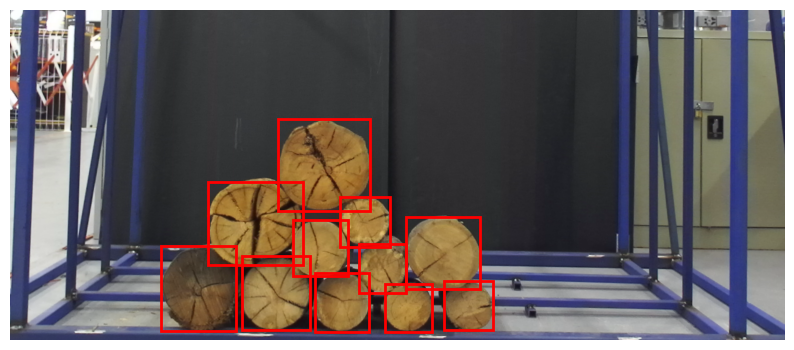

In [9]:
import matplotlib.pyplot as plt
import torchvision
import random

def visualize_sample(dataset, index=None):
    if index is None:
        index = random.randint(0, len(dataset) - 1)
    
    img, target = dataset[index]
    img = img.permute(1, 2, 0).numpy()
    
    boxes = target['boxes'].numpy()
    labels = target['labels'].numpy()
    masks = target['masks'].numpy()
    
    plt.figure(figsize=(10, 10))
    plt.imshow(img)
    
    ax = plt.gca()
    
    for box in boxes:
        xmin, ymin, xmax, ymax = box
        rect = plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin, fill=False, color='red', linewidth=2)
        ax.add_patch(rect)
    
    plt.axis('off')
    plt.show()

# Visualize a random training sample
visualize_sample(train_dataset)


In [11]:
import torch
import torchvision
from torchvision.models.detection import maskrcnn_resnet50_fpn
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor
import torch.optim as optim


# Load a pre-trained Mask R-CNN model
maskrcnn = maskrcnn_resnet50_fpn(weights='DEFAULT')

# Number of classes: 1 class ('log') + 1 background class = 2
num_classes = 2

# Replace the pre-trained head with a new one
in_features = maskrcnn.roi_heads.box_predictor.cls_score.in_features
maskrcnn.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

# Replace the mask predictor with a new one
in_features_mask = maskrcnn.roi_heads.mask_predictor.conv5_mask.in_channels
hidden_layer = 256
maskrcnn.roi_heads.mask_predictor = MaskRCNNPredictor(in_features_mask, hidden_layer, num_classes)

# Move the model to the device
maskrcnn.to(device)

# Define optimizer
params = [p for p in maskrcnn.parameters() if p.requires_grad]
base_lr = 0.005
optimizer = optim.SGD(params, lr=base_lr, momentum=0.9, weight_decay=0.0005)

# Warm-up settings
warmup_iters = 500  # Number of iterations for warm-up
warmup_factor = 1.0 / 1000  # Start at 1/1000th of the base learning rate
warmup_lr_scheduler = optim.lr_scheduler.LinearLR(optimizer, start_factor=warmup_factor, total_iters=warmup_iters)

# Normal learning rate scheduler (after warm-up)
lr_scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

# Number of epochs
num_epochs = 10
total_steps = 0

# Training loop
for epoch in range(num_epochs):
    print(f"Epoch {epoch+1}/{num_epochs}")
    maskrcnn.train()
    running_loss = 0.0
    
    for images, targets in train_loader:
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
        
        # Forward pass
        loss_dict = maskrcnn(images, targets)
        
        # Compute total loss
        losses = sum(loss for loss in loss_dict.values())
        
        # Backward pass
        optimizer.zero_grad()
        losses.backward()
        optimizer.step()
        
        # Apply the warm-up scheduler for the first few iterations
        if total_steps < warmup_iters:
            warmup_lr_scheduler.step()
        else:
            lr_scheduler.step()
        
        running_loss += losses.item()
        total_steps += 1
    
    avg_loss = running_loss / len(train_loader)
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}")

# Save the trained model
torch.save(maskrcnn.state_dict(), 'mask_rcnn_log_detector.pth')
print(f"Mask R-CNN model trained and saved.")

Epoch 1/10


In [ ]:
import torch
import matplotlib.pyplot as plt
from torchvision.utils import draw_bounding_boxes
import torchvision.transforms.functional as F

# Set model to evaluation mode
maskrcnn.eval()

# Function to draw bounding boxes and visualize them
def visualize_predictions(image, output, true_boxes, device):
    # Convert image to a valid range (0-255) for visualization
    image = (image * 255).byte()

    # Extract predicted bounding boxes and labels
    pred_boxes = output['boxes'].cpu()
    pred_labels = output['labels'].cpu()
    
    # Extract true bounding boxes
    true_boxes = true_boxes.cpu()
    
    # Create an overlay with predicted and true bounding boxes (for comparison)
    image_with_boxes = draw_bounding_boxes(image, boxes=pred_boxes, labels=[str(label.item()) for label in pred_labels], colors="red", width=3)
    image_with_true_boxes = draw_bounding_boxes(image, boxes=true_boxes, labels=['GT']*len(true_boxes), colors="green", width=3)

    # Convert to PIL image for plotting
    image_with_boxes_pil = F.to_pil_image(image_with_boxes)
    image_with_true_boxes_pil = F.to_pil_image(image_with_true_boxes)

    # Plot predictions and true boxes
    fig, ax = plt.subplots(1, 2, figsize=(12, 6))
    ax[0].imshow(image_with_true_boxes_pil)
    ax[0].set_title("True Bounding Boxes")
    ax[1].imshow(image_with_boxes_pil)
    ax[1].set_title("Predicted Bounding Boxes")
    plt.show()

# Function to evaluate the model and compute accuracy
def evaluate_model(model, dataloader, device):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, targets in dataloader:
            images = list(img.to(device) for img in images)
            outputs = model(images)
            
            # Iterate over the batch
            for i in range(len(outputs)):
                pred_labels = outputs[i]['labels'].cpu().numpy()
                true_labels = targets[i]['labels'].cpu().numpy()
                
                # Visualize the first image in the batch
                visualize_predictions(images[i].cpu(), outputs[i], targets[i]['boxes'], device)
                
                # Calculate accuracy
                correct += (pred_labels == true_labels).sum()
                total += len(true_labels)
    
    # Calculate accuracy percentage
    accuracy = 100 * correct / total if total > 0 else 0
    print(f'Validation Accuracy: {accuracy:.2f}%')

# Call the evaluation function
evaluate_model(maskrcnn, val_loader, device)
